In [103]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/INF2178")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Zonglin Li
1004910117

In [104]:
#load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install pingouin
import pingouin as pg
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.power import TTestIndPower
import statsmodels.api as sm
from patsy import dmatrices
import statsmodels.formula.api as smf
import scipy.stats
import statsmodels.stats.power as smp
from scipy import stats





In [106]:
# show dataset df
df = pd.read_csv('INF2178_A4_data.csv')
df.head(5)

,Unnamed: 0,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444


In [107]:
# data manuplation
df = pd.read_csv('INF2178_A4_data.csv')
selected_columns = ['Visit', 'Group', 'MMSE', 'Subject ID','M/F']  # Ensure the column names are correctly spelled
df_select = df[selected_columns]
df_select = df_select.dropna()
df_select = df_select[df_select['Group'] != 'Converted']
df_select.rename(columns={'M/F': 'gender'}, inplace=True)

print(df_select.head(5))

   Visit        Group  MMSE Subject ID gender
0      1  Nondemented  27.0  OAS2_0001      M
1      2  Nondemented  30.0  OAS2_0001      M
2      1     Demented  23.0  OAS2_0002      M
3      2     Demented  28.0  OAS2_0002      M
4      1  Nondemented  28.0  OAS2_0004      F


In [109]:
#show df_select info
df_select.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267 entries, 0 to 293
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Visit       267 non-null    int64  
 1   Group       267 non-null    object 
 2   MMSE        267 non-null    float64
 3   Subject ID  267 non-null    object 
 4   gender      267 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 12.5+ KB


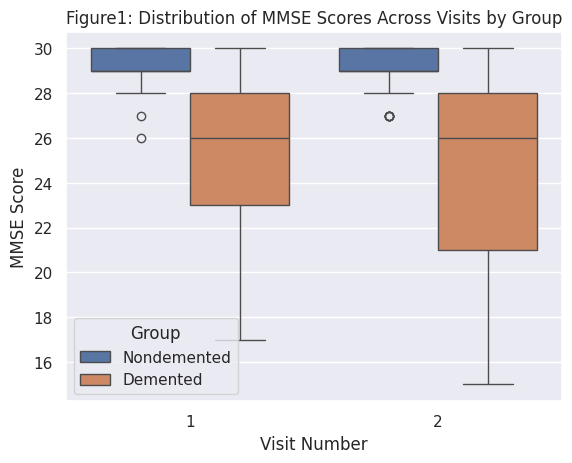

In [110]:
#  Box Plot for Distribution of MMSE Scores
sns.boxplot(data=df_select, x='Visit', y='MMSE', hue='Group')
plt.title('Figure1: Distribution of MMSE Scores Across Visits by Group')
plt.xlabel('Visit Number')
plt.ylabel('MMSE Score')
plt.legend(title='Group')
plt.show()


In [111]:
# Group the data and calculate descriptive statistics
stats = df_select.groupby(['Group', 'Visit'])['MMSE'].describe()

# Calculate the Interquartile Range (IQR), which helps to determine the length of the "whiskers" in the boxplot
stats['IQR'] = stats['75%'] - stats['25%']

# Calculate the lower and upper bounds for the "whiskers", typically extending to the furthest observation within 1.5 * IQR
stats['whisker_low'] = stats['25%'] - 1.5 * stats['IQR']
stats['whisker_high'] = stats['75%'] + 1.5 * stats['IQR']

# Adjust the whisker positions to ensure they do not go beyond the actual range of the data
stats['whisker_low'] = stats.apply(lambda row: max(row['whisker_low'], row['min']), axis=1)
stats['whisker_high'] = stats.apply(lambda row: min(row['whisker_high'], row['max']), axis=1)

# Display the results
print(stats[['min', 'whisker_low', '25%', '50%', '75%', 'whisker_high', 'max']])


                    min  whisker_low   25%   50%   75%  whisker_high   max
Group       Visit                                                         
Demented    1      17.0         17.0  23.0  26.0  28.0          30.0  30.0
            2      15.0         15.0  21.0  26.0  28.0          30.0  30.0
Nondemented 1      26.0         27.5  29.0  29.0  30.0          30.0  30.0
            2      27.0         27.5  29.0  29.0  30.0          30.0  30.0


In [112]:
## mixed-effects ANOVA (both within- and between-subjects)
## m exploratory data analysis, run 2 or more models, create output plots, and test the assumptions for running a mixed-effects ANOVA to earn the maximum points.
## Create a statistical power analysis plot for t-tests and tell us the appropriate sample size for a theoretical experiment with power = 0.91, alpha = 0.05, and effect size = 0.7


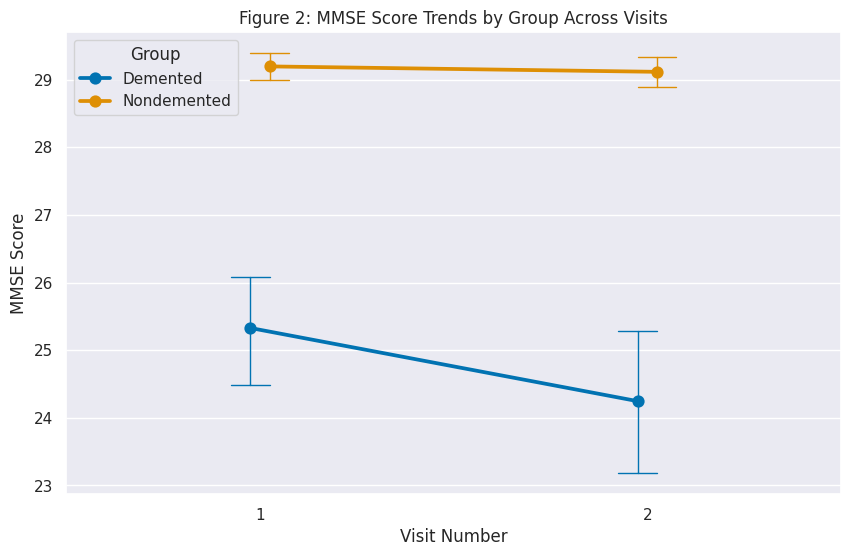

In [113]:
# Change 'Visit' and 'Group' are treated as categorical types to conduct further research
df_select['Visit'] = df_select['Visit'].astype('category')
df_select['Group'] = df_select['Group'].astype('category')

# Setting the seaborn style
sns.set()

# plot figures
plt.figure(figsize=(10, 6))
sns.pointplot(data=df_select, x='Visit', y='MMSE', hue='Group', dodge=True,
              capsize=.1, err_kws={'linewidth': 1}, palette='colorblind')

plt.title('Figure 2: MMSE Score Trends by Group Across Visits')
plt.xlabel('Visit Number')
plt.ylabel('MMSE Score')
plt.show()

In [114]:
# Group the DataFrame by 'Visit' and 'Group', then calculate the mean and standard deviation for 'MMSE' scores
summary_stats = df_select.groupby(['Visit', 'Group'])['MMSE'].agg(['mean', 'std']).round(2)

# Display the summary statistics
print(summary_stats)

                    mean   std
Visit Group                   
1     Demented     25.33  3.32
      Nondemented  29.19  0.85
2     Demented     24.25  4.40
      Nondemented  29.11  0.96


In [115]:
# Compute the two-way mixed-design ANOVA
aov = pg.mixed_anova(dv='MMSE', within='Visit', between='Group', subject='Subject ID', data=df_select)

# Pretty printing of ANOVA summary
pg.print_table(aov)


ANOVA SUMMARY

Source             SS    DF1    DF2        MS        F    p-unc    np2      eps
-----------  --------  -----  -----  --------  -------  -------  -----  -------
Group        1273.878      1    129  1273.878  101.443    0.000  0.440  nan
Visit          15.634      1    129    15.634    6.125    0.015  0.045    1.000
Interaction    13.078      1    129    13.078    5.123    0.025  0.038  nan



In [116]:


#Create ANOVA summary table for report
anova_summary = pd.DataFrame({
    'Source': ['Group', 'Visit', 'Interaction'],
    'SS': [1273.878, 15.634, 13.078],
    'DF1': [1, 1, 1],
    'DF2': [129, 129, 129],
    'MS': [1273.878, 15.634, 13.078],
    'F': [101.443, 6.125, 5.123],
    'p-unc': [0.000, 0.015, 0.025],
    'np2': [0.440, 0.045, 0.038],
    'eps': ['nan', 1.000, 'nan']
})

anova_summary.set_index('Source', inplace=True)
anova_summary



,SS,DF1,DF2,MS,F,p-unc,np2,eps
Source,,,,,,,,
Group,1273.878,1,129,1273.878,101.443,0.000,0.440,nan
Visit,15.634,1,129,15.634,6.125,0.015,0.045,1.0
Interaction,13.078,1,129,13.078,5.123,0.025,0.038,nan


In [117]:
# Conduct POST HOC TESTS
posthocs = pg.pairwise_ttests(dv='MMSE', within='Visit', between='Group',
                              subject='Subject ID', data=df_select, padjust='holm')
pg.print_table(posthocs)

/usr/local/lib/python3.10/dist-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)



POST HOC TESTS

Contrast       Visit    A         B            Paired    Parametric         T      dof  alternative      p-unc    p-corr  p-adjust                  BF10    hedges
-------------  -------  --------  -----------  --------  ------------  ------  -------  -------------  -------  --------  ----------  ------------------  --------
Visit          -        1         2            True      True           2.436  130.000  two-sided        0.016   nan      nan                      1.668     0.138
Group          -        Demented  Nondemented  False     True          -9.449   64.318  two-sided        0.000   nan      nan         22070000000000.000    -1.754
Visit * Group  1        Demented  Nondemented  False     True          -9.016   66.849  two-sided        0.000     0.000  holm         2117000000000.000    -1.668
Visit * Group  2        Demented  Nondemented  False     True          -8.463   64.937  two-sided        0.000     0.000  holm          110600000000.000    -1.570



In [118]:

#checking assumptions
#mauchly's test of spericity
pg.sphericity(data=df_select, dv='MMSE', subject='Subject ID', within='Visit')[-1]


1.0

In [119]:
#test of normality
pg.normality(data=df_select, dv='MMSE', group='Visit')

,W,pval,normal
Visit,,,
1,0.806517,4.109521e-12,False
2,0.760253,2.380533e-13,False


In [120]:
### model 2 MMSE Score Trends by gender Across Visits

df_select['gender'] = df_select['gender'].astype('category')

model = smf.mixedlm("MMSE ~ C(Visit)*C(gender)", data=df_select, groups=df_select["Subject ID"]).fit()
print(model.summary())




                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      MMSE     
No. Observations:       267          Method:                  REML     
No. Groups:             136          Scale:                   2.6298   
Min. group size:        1            Log-Likelihood:          -647.0251
Max. group size:        2            Converged:               Yes      
Mean group size:        2.0                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    27.949    0.391 71.546 0.000 27.183 28.714
C(Visit)[T.2]                -0.645    0.263 -2.455 0.014 -1.160 -0.130
C(gender)[T.M]               -1.345    0.598 -2.249 0.025 -2.518 -0.173
C(Visit)[T.2]:C(gender)[T.M]  0.347    0.405  0.858 0.391 -0.447  1.141
Group Var

In [121]:
#make table for report
regression_results = pd.DataFrame({
    'Term': ['Intercept', 'C(Visit)[T.2]', 'C(gender)[T.M]', 'C(Visit)[T.2]:C(gender)[T.M]'],
    'Coefficient': [27.949, -0.645, -1.345, 0.347],
    'Std.Err': [0.391, 0.263, 0.598, 0.405],
    'z': [71.546, -2.455, -2.249, 0.858],
    'P>|z|': [0.000, 0.014, 0.025, 0.391],
    'CI 95%': ['[27.183, 28.714]', '[-1.160, -0.130]', '[-2.518, -0.173]', '[-0.447, 1.141]'],
    'Group Var': [4.927, '-', '-', '-']
})

regression_results.set_index('Term', inplace=True)
regression_results



,Coefficient,Std.Err,z,P>|z|,CI 95%,Group Var
Term,,,,,,
Intercept,27.949,0.391,71.546,0.000,"[27.183, 28.714]",4.927
C(Visit)[T.2],-0.645,0.263,-2.455,0.014,"[-1.160, -0.130]",-
C(gender)[T.M],-1.345,0.598,-2.249,0.025,"[-2.518, -0.173]",-
C(Visit)[T.2]:C(gender)[T.M],0.347,0.405,0.858,0.391,"[-0.447, 1.141]",-


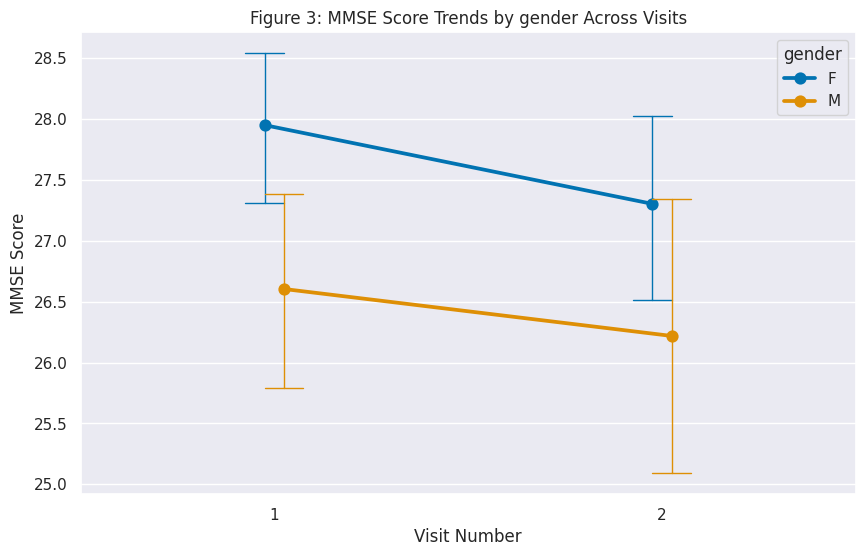

In [122]:
# Setting the seaborn style
sns.set()

# create MMSE Score trends by gender across visits
plt.figure(figsize=(10, 6))  # Setting the figure size
sns.pointplot(data=df_select, x='Visit', y='MMSE', hue='gender', dodge=True,
              capsize=.1, err_kws={'linewidth': 1}, palette='colorblind')

plt.title('Figure 3: MMSE Score Trends by gender Across Visits')
plt.xlabel('Visit Number')
plt.ylabel('MMSE Score')
plt.show()

In [123]:
# Normality Test
normality_results = pg.normality(data=df_select, dv='MMSE', group='Visit')
print(normality_results)



              W          pval  normal
Visit                                
1      0.806517  4.109521e-12   False
2      0.760253  2.380533e-13   False


In [124]:
# Homogeneity of variances
homogeneity_results = pg.homoscedasticity(data=df_select, dv='MMSE', group='Visit')
print(homogeneity_results)

               W      pval  equal_var
levene  1.588602  0.208635       True


In [125]:
# Calculate the sample size
power_analysis = smp.TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=0.7, power=0.91, alpha=0.05, ratio=1, alternative='two-sided')
sample_size


45.45073088568012

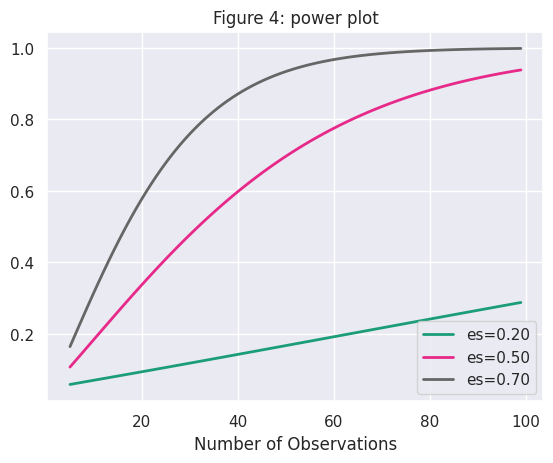

In [126]:
#power curves
# import required libraries
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower


# power analysis varying parameters
effect_sizes = np.array([0.2, 0.5, 0.7])
sample_sizes = np.array(range(5, 100))

# plot power curves
obj = TTestIndPower()
obj.plot_power(dep_var='nobs', nobs=sample_sizes,
			effect_size=effect_sizes)
plt.title('Figure 4: power plot')
plt.show()

In [127]:


# Set simulation parameters
num_runs = 5000  # Number of simulations to run
effect_size = 0.7  # Presumed effect size for power analysis

# Perform power analysis to calculate the required sample size
power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=effect_size, power=0.91, alpha=0.05)

# Round up the sample size to the nearest whole number
sample_size = np.int64(np.ceil(sample_size))

# Function to simulate a two-sample t-test and return the p-value
def simulate_t_test(sample_size, effect_size):
    # Generate normally distributed data for two groups
    group1 = np.random.normal(loc=0.0, scale=1.0, size=sample_size)
    group2 = np.random.normal(loc=effect_size, scale=1.0, size=sample_size)
    # Conduct the t-test and get the p-value
    _, p_value = ttest_ind(group1, group2)
    return p_value

# Simulate t-tests and collect p-values
p_values = [simulate_t_test(sample_size, effect_size) for _ in range(num_runs)]

# Estimate the power as the proportion of p-values below the significance level
power_estimate = np.mean(np.array(p_values) < 0.05)

# Output the estimated power from the simulation
print(f'Estimated power from simulation: {power_estimate}')




Estimated power from simulation: 0.9192
